In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import mplleaflet
import geopandas as gpd
import googlemaps
from glob import glob
import os
from copy import deepcopy
from kitchen.text.converters import to_unicode
from datetime import datetime
import pickle
myapikey = open('googkey1.txt', 'r').read()
goog = googlemaps.Client(myapikey)

import plotly.plotly as py
import plotly.graph_objs as go
from scipy.misc import imread
from datetime import date


import utils


In [2]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.metrics import confusion_matrix, consensus_score

In [415]:
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=13)
plt.rc('figure', titlesize=25)
plt.rc('axes', titlesize=13)
member_color = 'darkorange'
casual_color = 'royalblue'
all_color = 'darkcyan'

In [402]:
num = 5
blocs, weather, weather_code_names, bdata = utils.load_default()

Loading station infromation from saved file
Loading weather from saved file
Loading bikes with weather from saved file


In [404]:
# determine how many bikes leave each station
most_start = bdata['start_station_code'].value_counts()
# determine how many bikes are racked at each station
most_end = bdata['end_station_code'].value_counts()
# add both together so we can pick stations which are popular
most_both = most_start+most_end
most_both = most_both.sort_values(axis=0, ascending=False)
blocs.index = blocs['code']
blocs['start events'] = most_start
blocs['end events'] = most_end
blocs['events'] = most_both
ismem = bdata.loc[:,'is_member']>0
bdatamem = bdata[ismem]
bdatacas = bdata[~ismem]
# determine how many bikes leave each station
most_start_mem = bdatamem['start_station_code'].value_counts()
# determine how many bikes are racked at each station
most_end_mem = bdatamem['end_station_code'].value_counts()
# determine how many bikes leave each station
most_start_cas = bdatacas['start_station_code'].value_counts()
# determine how many bikes are racked at each station
most_end_cas = bdatacas['end_station_code'].value_counts()
blocs['start events cas'] = most_start_cas
blocs['end events cas'] = most_end_cas
blocs['start events mem'] = most_start_mem
blocs['end events mem'] = most_end_mem

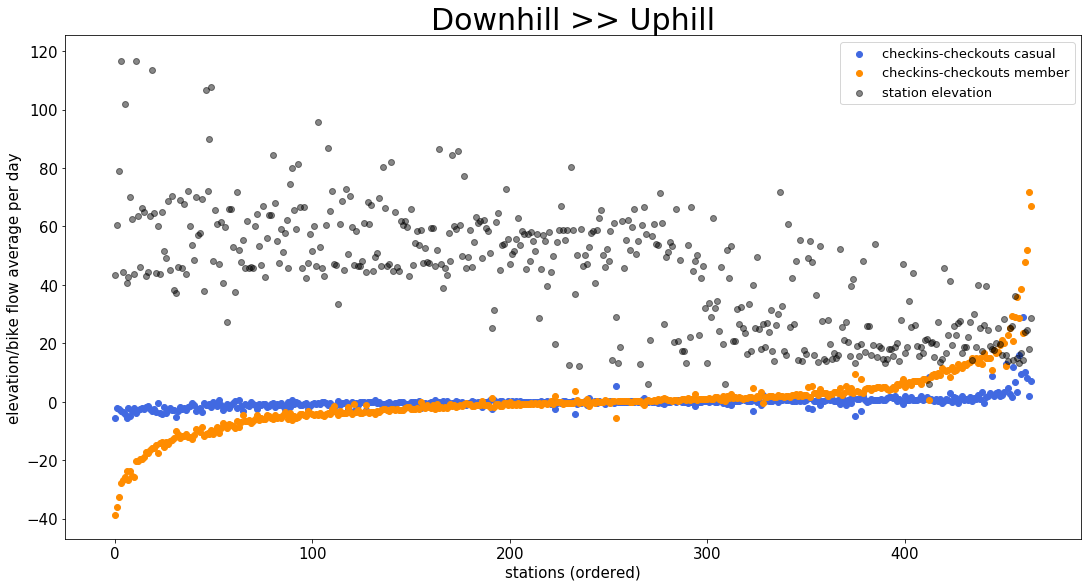

In [419]:
# Am I the only lazy one who finds it impossible to take a bixi uphill?
blocs.sort_values(axis=0, by='events', inplace=True, ascending=False)
total_days = float(bdata['day of year'].unique().shape[0])
stati = blocs.index
start_e = np.array(blocs['start events'])/total_days
end_e = np.array(blocs['end events'])/total_days
stat_names = blocs['name fmt']

stat_r = np.arange(start_e.shape[0])
diff = end_e-start_e
diff_sorted = sorted(zip(stati,  diff, stat_names), key=lambda group: group[1])
diff_sorted_code = [d[0] for d in diff_sorted]
diff_sorted_val = [d[1] for d in diff_sorted]
diff_sorted_name = [d[2] for d in diff_sorted]
diff_sorted_val = np.array(diff_sorted_val)


start_cas = np.array(blocs.loc[np.array(diff_sorted_code), 'start events cas'])/total_days
end_cas = np.array(blocs.loc[np.array(diff_sorted_code), 'end events cas'])/total_days
diff_cas = end_cas-start_cas
start_mem = np.array(blocs.loc[np.array(diff_sorted_code), 'start events mem'])/total_days
end_mem = np.array(blocs.loc[np.array(diff_sorted_code), 'end events mem'])/total_days
diff_mem = end_mem-start_mem

dis_name = np.array(blocs.loc[diff_sorted_code,'name fmt'])
dis_elev = blocs.loc[diff_sorted_code,'elev']
f, ax = plt.subplots(figsize=(15,8))
#plt.scatter(stat_r, diff_sorted_val, label='checkins-checkouts', c=all_color)
plt.scatter(stat_r, diff_cas, label='checkins-checkouts casual', c=casual_color)
plt.scatter(stat_r, diff_mem, label='checkins-checkouts member', c=member_color)
plt.scatter(stat_r, dis_elev, label='station elevation', c='k', alpha=.47)
#plt.scatter(stat_r, dis_dt, label='distance to dt', c='k', alpha=.17)
plt.legend()
ax.set_title("Downhill >> Uphill", fontsize=30)
plt.tight_layout()
plt.ylabel('elevation/bike flow average per day', fontsize=15)
plt.xlabel('stations (ordered)', fontsize=15)
#ss = plt.xticks(np.arange(0, blocs.shape[0], 50), rotation=70)
#labels = ax.get_xticks().tolist()
#olabels = [diff_sorted_name[int(x)] for x in labels]
#sq = ax.set_xticklabels(olabels)

In [465]:
min_elevs = [6504,6501,6109]
max_elevs = [6928,6306]

In [469]:
s_drap = bdata['start_station_code']==6501
e_jb = bdata['end_station_code']==6316
dr_jb = np.argmax((s_drap & e_jb))
#bdata.loc[dr_jb,:]

In [375]:
# trips taken by members
percentage_trip_member = bdatamem.shape[0]/float(bdata.shape[0])
time_member = bdatamem['duration_min'].mean()
time_casual = bdatacas['duration_min'].mean()
time_all = bdata['duration_min'].mean()
overflow_member = sum(bdatamem['duration_min']>45)/float(bdatamem.shape[0])
overflow_casual = sum(bdatacas['duration_min']>45)/float(bdatacas.shape[0])
overflow_all = sum(bdata['duration_min']>45)/float(bdata.shape[0])

In [470]:
diffmem = bdatamem['start_station_elev']-bdatamem['end_station_elev']
mindiff = min(diffmem)
bdatamem.loc[np.argmin(diffmem),:]

Unnamed: 0                                                          2193339
start_date                                              2016-08-03 15:55:00
start_station_code                                                     6501
end_date                                                2016-08-03 17:01:00
end_station_code                                                       6316
duration_sec                                                           3942
is_member                                                                 1
filename_x                                                   OD_2016-08.csv
orig index                                                            63303
all index                                                           2193339
duration_min                                                           65.7
dt_x                                                    2016-08-03 15:55:00
weekday                                                                   2
year        

In [439]:
maxdiff = max(diffmem)
bdatamem.loc[np.argmax(diffmem),:]

Unnamed: 0                                                          1899828
start_date                                              2016-07-22 12:55:00
start_station_code                                                     6306
end_date                                                2016-07-22 13:28:00
end_station_code                                                       6501
duration_sec                                                           2030
is_member                                                                 1
filename_x                                                   OD_2016-07.csv
orig index                                                           486127
all index                                                           1899828
duration_min                                                        33.8333
dt_x                                                    2016-07-22 12:55:00
weekday                                                                   4
year        

In [431]:
diffcas = bdatamem['start_station_elev']-bdatamem['end_station_elev']
max(diffcas)

110.7

In [428]:
np.sum(bdatacas['start_station_elev']-bdatacas['end_station_elev']>-10)/float(bdatacas.shape[0])

0.79075692736471559

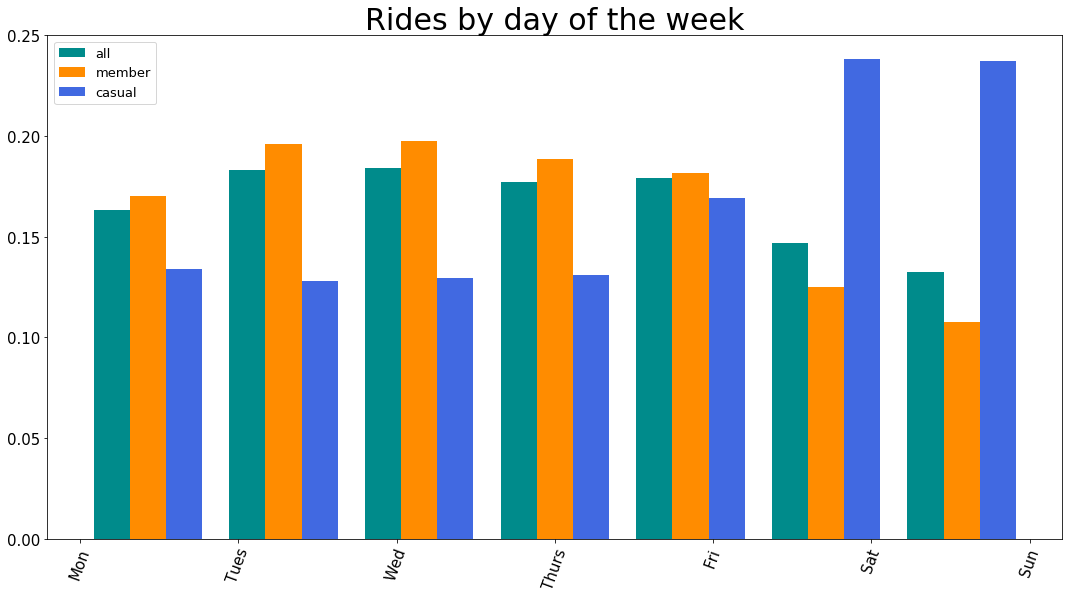

In [355]:
hdata = [bdata['weekday'],
         bdatamem['weekday'],
         bdatacas['weekday']]
colors = [all_color, member_color, casual_color]
f, ax = plt.subplots(figsize=(15,8))
plt.hist(hdata, 7, stacked=False, histtype='bar', normed=True, color=colors, label=['all', 'member', 'casual'])
plt.legend()
ax.set_title("Rides by day of the week", fontsize=30)
plt.tight_layout()
ss = plt.xticks(range(7), rotation=70)
dlabels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
sq = ax.set_xticklabels(dlabels)

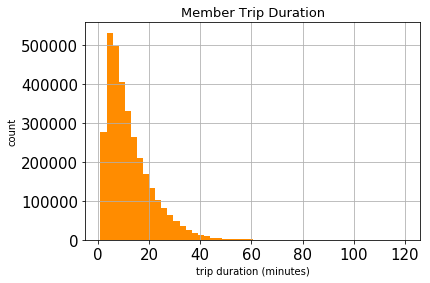

In [342]:
bdatamem.hist(column='duration_min', bins=50, color=member_color)
plt.title("Member Trip Duration")
plt.ylabel("count")
plt.xlabel("trip duration (minutes)")

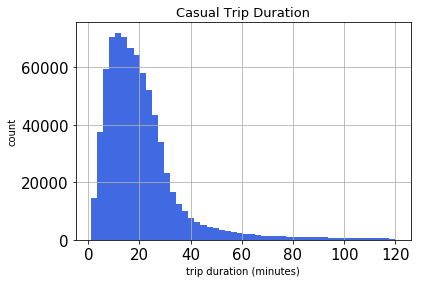

In [341]:
bdatacas.hist(column='duration_min', bins=50, color=casual_color)
plt.title("Casual Trip Duration")
plt.ylabel("count")
plt.xlabel("trip duration (minutes)")

# Plot all of the bike rides

In [393]:
plt.figure(figsize=(10,10))
plt.scatter(np.array(blocs['longitude']),  np.array(blocs["latitude"]),
            c=blocs['events'], cmap=plt.cm.hot, edgecolor='face', alpha=.8,  s=40, )    
plt.axis('tight')
mplleaflet.display()

In [410]:
bdata.loc[np.argmax(bdata['duration_min']),:]

Unnamed: 0                                                           850904
start_date                                              2016-06-04 14:17:00
start_station_code                                                     6085
end_date                                                2016-06-04 16:17:00
end_station_code                                                       6901
duration_sec                                                           7199
is_member                                                                 0
filename_x                                                   OD_2016-06.csv
orig index                                                            82651
all index                                                            850904
duration_min                                                        119.983
dt_x                                                    2016-06-04 14:17:00
weekday                                                                   5
year        

In [ ]:
memdaily = mem['total interacts'].groupby().count()

In [151]:
# number of stations we want to tackle
num_stats = 10
# keep num_stats most popular stations
stations = most_both.index[:num_stats]
# lets look at which stations are the most popular
for xx, st_num in enumerate(stations):
    st_name = blocs.loc[blocs['code']==st_num,'name'].values[0]
    print("%s: Station number: %s (%s) had %s bike events" %(xx, st_num, st_name, int(most_both[st_num])))
# make new dataset consisting of only popular stations
pop_bdata = tfilt_bdata[tfilt_bdata['start_station_code'].isin(stations)]
pop_bdata = pop_bdata[pop_bdata['end_station_code'].isin(stations)]

pop_blocs = blocs[blocs['code'].isin(stations)]

0: Station number: 6078 (de Maisonneuve / de Bleury) had 70106 bike events
1: Station number: 6100 (Mackay /de Maisonneuve (Sud)) had 68229 bike events
2: Station number: 6184 (Métro Mont-Royal (Rivard / du Mont-Royal)) had 63115 bike events
3: Station number: 6136 (Métro Laurier (Rivard / Laurier)) had 62012 bike events
4: Station number: 6064 (de Maisonneuve / Stanley) had 58495 bike events
5: Station number: 6015 (Berri / de Maisonneuve) had 54987 bike events
6: Station number: 6070 (Milton / Université) had 50659 bike events
7: Station number: 6012 (Métro St-Laurent (de Maisonneuve / St-Laurent)) had 49763 bike events
8: Station number: 6221 (du Mont-Royal / Clark) had 45067 bike events
9: Station number: 6154 (Marquette / du Mont-Royal) had 44387 bike events


,Temp,dt,Wind Dir (10s deg),Rel Hum (%),Weather,filename,w orig index
0,0.1,2014-04-01 00:00:00,6.0,72.0,NaN,eng-hourly-04012014-04302014.csv,0
1,-0.9,2014-04-01 01:00:00,5.0,78.0,Clear,eng-hourly-04012014-04302014.csv,1
2,-1.1,2014-04-01 02:00:00,3.0,78.0,NaN,eng-hourly-04012014-04302014.csv,2
3,-1.8,2014-04-01 03:00:00,1.0,80.0,NaN,eng-hourly-04012014-04302014.csv,3
4,-2.8,2014-04-01 04:00:00,35.0,85.0,Clear,eng-hourly-04012014-04302014.csv,4


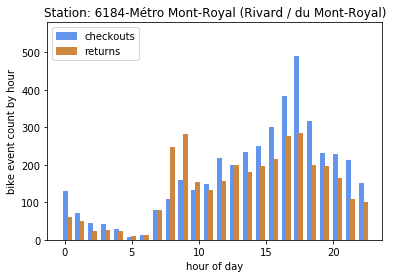

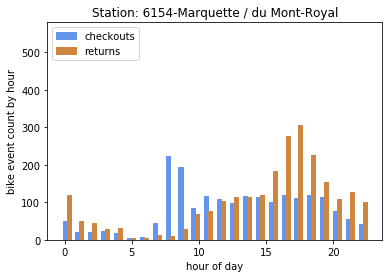

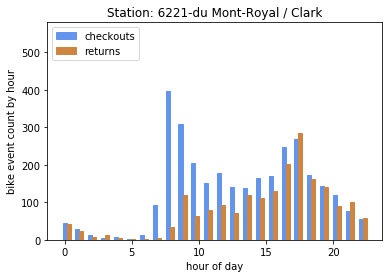

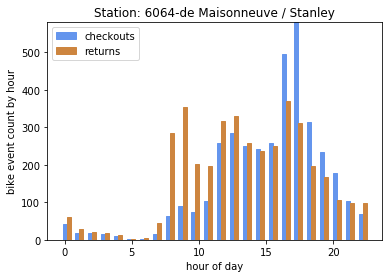

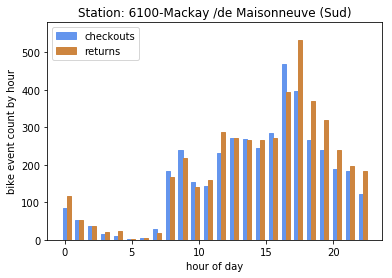

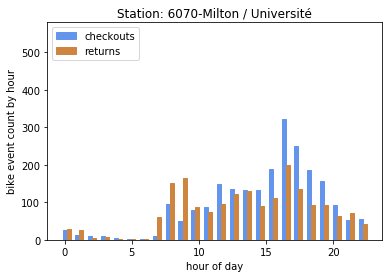

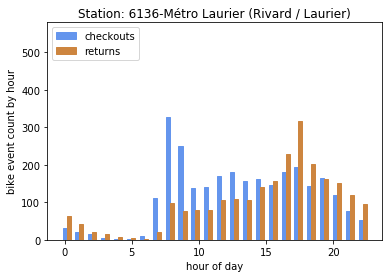

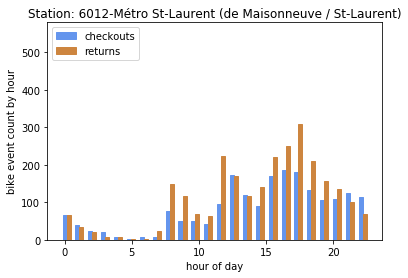

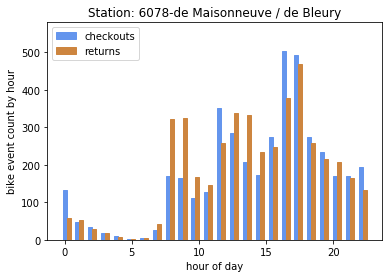

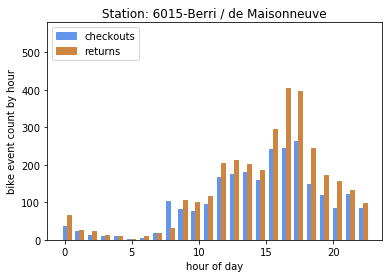

In [155]:
# plot histogram of checkin/checkouts
stat_stats = []
max_height = 0
for code in set(wpop_bdata['end_station_code']):
    # gather histograms of station checkin/out times
    t_name = str(code) + '-' + to_unicode(blocs.loc[blocs['code']==code,'name'].values[0], 'utf-8').strip()
    st_heights, st_bins = np.histogram(wpop_bdata[wpop_bdata['start_station_code'] == code]['start hour'], bins=24)
    en_heights, en_bins = np.histogram(wpop_bdata[wpop_bdata['end_station_code'] == code]['end hour'], bins=st_bins)
    stat_stats.append([t_name, st_bins, en_bins, st_heights, en_heights, code])
    tmaxh = max(st_heights.max(), en_heights.max())
    if tmaxh>max_height:
        max_height = tmaxh

width = .3
for t_name, st_bins, en_bins, st_heights, en_heights, code in stat_stats:
    # plot everything now that we know the parameters of all of the stations
    fig, ax = plt.subplots()
    ax.bar(st_bins[:-1], st_heights, width=width, edgecolor='cornflowerblue', 
           color='cornflowerblue', label='checkouts')
    ax.bar(en_bins[:-1]+width, en_heights, width=width, 
           edgecolor='peru', color='peru', label='returns')
    
    plt.ylim([0,max_height])
    plt.legend(loc='upper left')
    plt.ylabel('bike event count by hour')
    plt.xlabel('hour of day')
    plt.title("Station: %s" %t_name)


In [156]:
# find the hourly checkin/checkouts by station
stations={}
start = min(wpop_bdata.loc[0,'start_date'], wpop_bdata.loc[0,'end_date'])
end = max(wpop_bdata.loc[wpop_bdata.shape[0]-1,'start_date'], wpop_bdata.loc[wpop_bdata.shape[0]-1,'end_date'])
start = start.floor('1H')
end = end.ceil('1H')
stations_hourly = pd.DataFrame()
for station in list(wpop_bdata['start_station_code'].unique()):
    this_station_st = wpop_bdata[wpop_bdata['start_station_code'] == station]
    this_station_en = wpop_bdata[wpop_bdata['end_station_code'] == station]
    stations[station] = {'checkout':deepcopy(this_station_st), 
                         'checkin':deepcopy(this_station_en)}
    this_station_st.index = this_station_st['start_date']
    this_station_en.index = this_station_en['end_date']
    
    checkins = this_station_st['instance'].resample('1H').count()
    checkouts = this_station_en['instance'].resample('1H').count()
    weather = this_station_st['Weather Code'].resample('1H').last()
    weatherfill = this_station_st['Weather Fill'].resample('1H').last()
    temp = this_station_st['Temp'].resample('1H').mean()

    hourly = pd.DataFrame(index=pd.date_range(start, end, freq='1H'), columns={'checkins', 'checkouts'})
    hourly['checkins'] = checkins
    hourly['checkouts'] = checkouts
    hourly['Weather Code'] = weather
    hourly['Weather Fill'] = weatherfill
    hourly['Temp'] = temp
    hourly['hour'] = hourly.index.hour
    
    avg_hourly_checkins = hourly['checkins'].groupby(hourly.index.hour).mean()
    avg_hourly_checkouts = hourly['checkouts'].groupby(hourly.index.hour).mean()
    count_hourly_checkins = hourly['checkins'].groupby(hourly.index.hour).count()
    count_hourly_checkouts = hourly['checkouts'].groupby(hourly.index.hour).count()
    stations_hourly.loc[:, 'st_'+str(station)] = avg_hourly_checkouts
    stations_hourly.loc[:, 'en_'+str(station),] = avg_hourly_checkouts


    stations[station]['hourly count'] = hourly
    


In [157]:
stations = wpop_bdata['start_station_code'].unique()
stat_dis = zip(stations, dist_dt)
stat_sort = sorted(stat_dis,key=lambda tup:tup[1])
stations_sorted = [s[0] for s in stat_sort]


In [158]:
def find_per_station_traffic(df, stations):
    # find count from station to station at time
    
    statcor = pd.DataFrame(columns=stations)
    statcorM = np.zeros((len(stations), len(stations), 24))
    
    for ssi, start_station in enumerate(stations):
        sstat = df[df.loc[:,'start_station_code']==start_station]
        station_departures = float(sstat.shape[0])
        for esi, end_station in enumerate(stations):
            estat = sstat[sstat.loc[:,'end_station_code']==end_station]
            departures = []
            for ii in range(24):
                departure = estat[estat['start hour'] == ii].shape[0]/station_departures
                departures.append(departure)
                statcorM[ssi, esi, ii] = departure
          
            statcor[start_station,end_station] = departures
    return stations, statcor, statcorM
 
def find_station_correspondence(df, stations):
    # find count from station to station at time
    
    statcor = pd.DataFrame(columns=stations)
    statcorM = np.zeros((len(stations), len(stations), 24))
    
    for ssi, start_station in enumerate(stations):
        sstat = df[df.loc[:,'start_station_code']==start_station]
        station_departures = float(sstat.shape[0])
        for esi, end_station in enumerate(stations):
            estat = sstat[sstat.loc[:,'end_station_code']==end_station]
            
            departures = []
            for ii in range(24):
                departure = estat[estat['start hour'] == ii].shape[0]
                departures.append(departure)
                statcorM[ssi, esi, ii] = departure
          
            statcor[start_station,end_station] = departures
    return stations, statcor, statcorM
 
stations, statcor, statcorM = find_station_correspondence(wpop_bdata, stations_sorted)
stations, stattraf, stattrafM = find_per_station_traffic(wpop_bdata, stations_sorted)


In [159]:
%pylab inline
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=1, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

Populating the interactive namespace from numpy and matplotlib


/Users/jhansen/anaconda/envs/bare27/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['datetime', 'imread', 'e', 'display']
`%matplotlib` prevents importing * from pylab and numpy



In [160]:
import matplotlib.animation as animation
from IPython import display
from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))
def _blit_draw(self, artists, bg_cache):
    # Handles blitted drawing, which renders only the artists given instead
    # of the entire figure.
    updated_ax = []
    for a in artists:
        # If we haven't cached the background for this axes object, do
        # so now. This might not always be reliable, but it's an attempt
        # to automate the process.
        if a.axes not in bg_cache:
            # bg_cache[a.axes] = a.figure.canvas.copy_from_bbox(a.axes.bbox)
            # change here
            bg_cache[a.axes] = a.figure.canvas.copy_from_bbox(a.axes.figure.bbox)
        a.axes.draw_artist(a)
        updated_ax.append(a.axes)

    # After rendering all the needed artists, blit each axes individually.
    for ax in set(updated_ax):
        # and here
        # ax.figure.canvas.blit(ax.bbox)
        ax.figure.canvas.blit(ax.figure.bbox)
        
# MONKEY PATCH!!
matplotlib.animation.Animation._blit_draw = _blit_draw

In [54]:
blocs.head()

,code,name,latitude,longitude,filename,year,distance_to_downtown
code,,,,,,,
6315,6315,Lacombe / de la Côte-des-Neiges,45.496851,-73.623320,Stations_2016.csv,2016,4.312364
6019,6019,Berri / Sherbrooke,45.517910,-73.567143,Stations_2016.csv,2016,1.548566
6347,6347,Métro St-Michel (Shaughnessy / St-Michel),45.559199,-73.599658,Stations_2016.csv,2016,6.578266
6219,6219,de l'Hôtel-de-Ville / Roy,45.517333,-73.574436,Stations_2016.csv,2016,1.534583
6211,6211,Roy / St-Laurent,45.515610,-73.575690,Stations_2016.csv,2016,1.384648


In [162]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(statcorM[:,:,0], vmin=0, vmax=250, origin='lower')


x1=ax.set_xticks(range(len(stations)))
x2=ax.set_xticklabels(labs, rotation=270)
x3=ax.set_yticks(range(len(stations)))
x4=ax.set_yticklabels(labs, rotation=0)

ax.set_xlabel("Checkins",fontsize=12)
ax.set_ylabel("Checkouts", fontsize=12)
ttl = plt.title("Bike Station Correspondance at %02d hours" %0)

fig.tight_layout()
def corinit():
    im.set_data(statcorM[:,:,0])
    return im,
def coranimate(i):
    o = int(i) + 5
    ttl.set_text("Bike Station Correspondance at %02d:00-%02d:00 hours" %(o,o+1))
    # [startstation,endstation,hour]
    im.set_data(statcorM[:,:,o])
    return im,
    
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, coranimate, init_func=corinit,
                               frames=18, interval=100, blit=True)

# call our new function to display the animation
display_animation(anim)


In [163]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.matshow(stattrafM[:,:,0], origin='lower')
labs = [format_station_print(blocs_dict[c]) for c in stations]
ax.xaxis.set_ticks_position('bottom')
x1=ax.set_xticks(range(len(stations)))
x2=ax.set_xticklabels(labs, rotation=90)
x3=ax.set_yticks(range(len(stations)))
x4=ax.set_yticklabels(labs, rotation=0)

ax.set_xlabel("Checkins",fontsize=12)
ax.set_ylabel("Checkouts", fontsize=12)
ttl = plt.title("Bike Station Correspondance at %02d hours" %0, fontsize=20)

fig.tight_layout()
def traf_init():
    im.set_data(statcorM[:,:,0])
    return im,
def traf_animate(i):
    o = int(i) + 5
    ttl.set_text("Station Relative Traffic at %02d:00-%02d:00 hours" %(o,o+1))
    # [startstation,endstation,hour]
    im.set_data(stattrafM[:,:,o])
    return im,
    
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, traf_animate, init_func=traf_init,
                               frames=18, interval=100, blit=True)

# call our new function to display the animation
display_animation(anim)


In [164]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.matshow(statcorM[:,:,0], origin='lower')
labs = [format_station_print(blocs_dict[c]) for c in stations]
ax.xaxis.set_ticks_position('bottom')
x1=ax.set_xticks(range(len(stations)))
x2=ax.set_xticklabels(labs, rotation=90)
x3=ax.set_yticks(range(len(stations)))
x4=ax.set_yticklabels(labs, rotation=0)

ax.set_xlabel("Checkins",fontsize=12)
ax.set_ylabel("Checkouts", fontsize=12)
ttl = plt.title("Bike Station Correspondance at %02d hours" %0,fontsize=20)

fig.tight_layout()
def init():
    im.set_data(statcorM[:,:,0])
    return im,
def animate(i):
    o = int(i) + 5
    ttl.set_text("Bike Station Correspondance at %02d:00-%02d:00 hours" %(o,o+1))
    # [startstation,endstation,hour]
    im.set_data(statcorM[:,:,o])
    return im,
    
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=18, interval=100, blit=True)

# call our new function to display the animation
display_animation(anim)



In [174]:
def create_hourly_dataset(df, station=6221):
    print("Creating hourly dataset for station: %s" %station)
    sstat = df[df.loc[:,'start_station_code']==station]
    estat = df[df.loc[:,'end_station_code']==station]
    sstat.index = sstat['start_date']
    estat.index = estat['end_date']
    
    start_count = sstat.resample("1H")['start_date'].count()
    end_count = estat.resample("1H")['end_date'].count()
    events = (start_count==0) + (end_count==0)
    events = events.fillna(value=1)
    
    ws = sstat['Weather Code'].resample("1H").last().ffill()
    wf = sstat['Weather Fill'].resample("1H").last().ffill()
    hol = sstat['isholiday'].resample("1H").last().ffill()
    wd = sstat['weekday'].resample("1H").last().ffill()
    ts = sstat['Temp'].resample("1H").last()
    tss = ts.interpolate(method='linear')
    num_nans = np.sum(np.isnan(np.array(tss)))
    h = pd.concat([ws, hol, tss, wf, wd, start_count, end_count], axis=1)
    
    h['start_date'] = h['start_date'].fillna(value=0)
    h['end_date'] = h['end_date'].fillna(value=0)
    h.loc[:,'Temp'] = h['Temp'].fillna(method='ffill')
    h.loc[:,'Temp'] = h['Temp'].fillna(method='bfill')

    h.loc[:,'Weather Code'] = h['Weather Code'].bfill()
    h.loc[:,'Weather Fill'] = h['Weather Fill'].bfill()
    h.loc[:,'weekday'] = h['weekday'].bfill()
    h.loc[:,'weekday'] = h['weekday'].ffill()
    h.loc[:,'Weather Code'] = h['Weather Code'].ffill()
    h.loc[:,'Weather Fill'] = h['Weather Fill'].ffill()
    
    h.loc[:,'sum count'] = h['start_date'] - h['end_date']
    h['hour'] = h.index.hour
    h['minute'] = h.index.minute
    h['year'] = h.index.year
    h['date'] = h.index.date

    h['day of year'] = h.index.dayofyear
    h['day of week'] = h.index.dayofweek
    h['date'] = pd.to_datetime(h.index)
    num_nans = np.sum(np.isnan(np.array(h['Temp'])))
    num_hols = np.sum((np.array(h['Temp'])))
    
    arrivals = []
    departures = []
    for ii in range(24):
        sthis_hour = start_count.index.hour == ii
        departure = np.sum(start_count[sthis_hour])
        
        ethis_hour = end_count.index.hour == ii
        arrival = np.sum(end_count[ethis_hour])

        arrivals.append(arrival)
        departures.append(departure)

    return h, arrivals, departures, sstat, estat
hh, aa, dd, s, e = create_hourly_dataset(wpop_bdata, 6100)
for code in wpop_bdata['start_station_code'].unique()[:5]:
    hh, aa, dd, s, e = create_hourly_dataset(wpop_bdata, code)
    pickle.dump( {'hourly':hh, 'arrivals':aa, 'departures':dd}, 
               open('station%s.pkl'%code, 'w'))


Creating hourly dataset for station: 6100
('NUM NANS TEMP', 0, 'holidays', 86315.450000000012)
Creating hourly dataset for station: 6100
('NUM NANS TEMP', 0, 'holidays', 86315.450000000012)
Creating hourly dataset for station: 6154
('NUM NANS TEMP', 0, 'holidays', 87494.25)
Creating hourly dataset for station: 6136
('NUM NANS TEMP', 0, 'holidays', 88130.449999999997)
Creating hourly dataset for station: 6184
('NUM NANS TEMP', 0, 'holidays', 85986.899999999994)
Creating hourly dataset for station: 6070
('NUM NANS TEMP', 0, 'holidays', 89961.450000000012)


In [175]:
hh.head()

,Weather Code,isholiday,Temp,Weather Fill,weekday,start_date,end_date,sum count,hour,minute,year,date,day of year,day of week
start_date,,,,,,,,,,,,,,
2016-04-15 08:00:00,0.0,0.0,4.700000,Clear,4.0,1,1.0,0.0,8,0,2016,2016-04-15 08:00:00,106,4
2016-04-15 09:00:00,0.0,0.0,6.933333,Clear,4.0,0,0.0,0.0,9,0,2016,2016-04-15 09:00:00,106,4
2016-04-15 10:00:00,0.0,0.0,9.166667,Clear,4.0,0,0.0,0.0,10,0,2016,2016-04-15 10:00:00,106,4
2016-04-15 11:00:00,0.0,0.0,11.400000,Clear,4.0,1,1.0,0.0,11,0,2016,2016-04-15 11:00:00,106,4
2016-04-15 12:00:00,0.0,0.0,11.900000,Clear,4.0,2,1.0,1.0,12,0,2016,2016-04-15 12:00:00,106,4


In [166]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [167]:

def make_cyclic(x, max_cycle):
    max_cycle = float(max_cycle)
    c = (x % max_cycle)/max_cycle * 2.0 * np.pi
    return np.sin(c), np.cos(c)

def create_X(hourly):
    wf = np.array(hourly['Weather Code'])
    ss = list(set(wf))
    
    wcn = [weather_code_names[int(xx)] for xx in ss]
    wfoh = np.zeros((wf.shape[0], len(ss)))
    for xx, s in enumerate(ss):
        wfoh[wf==s,xx] = 1
    
    t1,t2 = make_cyclic(np.array(hourly['hour'])+np.array(hourly['minute'])/60.,24)
    y1,y2 = make_cyclic(hourly['day of year'], 365.)
    w1,w2 = make_cyclic(hourly['day of week'], 7.)

    nn = t1.shape[0]
    aX = np.array(hourly[[ 'Temp']])

    aX_scaled  = preprocessing.scale(aX)
    X = np.concatenate(( t1[:,None],t2[:,None], aX_scaled,
                        w1[:,None],w2[:,None], y1[:,None], y2[:,None],
                         wfoh,
                       ),axis=1)
    labels = ['time1', 'time2', 'Temp', 'day wk1',  'day wk2', 'day year1', 'day year2']+wcn
    return X, labels

def create_model(hourly, station_code):
    #rf = BaggingClassifier(n_estimators=100, random_state=10)
    #rf = BaggingRegressor(n_estimators=100, random_state=10)
    rf = RandomForestClassifier(n_estimators=100, random_state=10)
    
    #rf = RandomForestRegressor(n_estimators=100, random_state=10)
    #hourly =hourly.loc[hourly['hour']>6]
    X, labels = create_X(hourly)
    y = np.array(hourly['sum count'])
    y_choice = list(set(y))
     #preprocessing.scale(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15,  random_state=10)
    
    o = rf.fit(X_train,y_train)
    rf.score(X_train,y_train)
   
    #print("X",X.shape,'y',y.shape)
    y_pred = rf.predict(X)
    y_test_pred = rf.predict(X_test)

    yerr =  mean_squared_error(y, y_pred)
    ytesterr = mean_squared_error(y_test,y_test_pred)

    
    y_pred = rf.predict(X)
    yy_test = np.zeros_like(y_test)
    yy_test[y_test>1] = 1
    yy_test[y_test<-1] = -1
    yy_test_pred = np.zeros_like(y_test_pred)
    yy_test_pred[y_test_pred>1] = 1
    yy_test_pred[y_test_pred<-1] =-1
    
   
    cf = confusion_matrix(yy_test, yy_test_pred, labels=[-1,0,1])
    #plot_confusion_matrix(cf, classes=[-1,0,1], title='station:%s'%station_code)
    
    return X, y, rf, labels


In [176]:
codes = wpop_bdata['start_station_code'].unique()
datas = {}

for code in [6154]:
    hourly,  aa, dd, starts, ends = create_hourly_dataset(wpop_bdata, code)
    
    print('station', blocs_dict[code], code)
    X, y, rf, labels = create_model(hourly, code)
    
    datas[code] = {"X":X, 'y':y, 'rf':rf}

Creating hourly dataset for station: 6154
('NUM NANS TEMP', 0, 'holidays', 87494.25)
('station', 'Marquette / du Mont-Royal', 6154)


In [169]:
pp = deepcopy(hourly)
pp.columns
pp = pp[pp.loc[:,'day of year']==150]
#pp['end_date'].plot()

In [182]:

days = hourly['day of year'].unique()
ddata = np.zeros((days.shape[0], 24))
dts = []
for xx, day in enumerate(days):
    ss = hourly[hourly['day of year'] == day]
    dts.append(ss.index[0])
    ddata[xx,list(ss['hour'])] =  list(ss['sum count'])
    
   

In [231]:
outq = np.zeros((days.shape[0], 5))
outq[:,0] = np.sum(ddata[:,0:5], axis=1) # night
outq[:,1] = np.sum(ddata[:,5:10], axis=1) # morning
outq[:,2] = np.sum(ddata[:,10:15], axis=1) # lunch
outq[:,3] = np.sum(ddata[:,15:20], axis=1) # evening
outq[:,4] = np.sum(ddata[:,20:24], axis=1)

array([[ 0.,  1., -3., -3., -1.],
       [ 1.,  2., -2.,  1., -1.],
       [ 1.,  1.,  5.,  0.,  0.],
       ..., 
       [-1.,  1., -1.,  1., -1.],
       [ 0.,  0.,  1.,  0.,  1.],
       [ 0.,  3., -2., -6., -2.]])

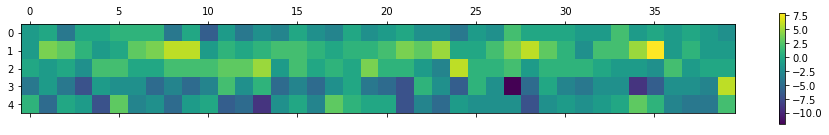

In [233]:
plt.figure(figsize=(10,15))
plt.matshow(outquantize[60:100,:].T)
#plt.ylabel(dts[80:150])
plt.colorbar()

In [ ]:

f,ax=plt.subplots(figsize=(15,8))
plt.title("Feature Importances")
ax.bar(np.arange(rf.feature_importances_.shape[0]), rf.feature_importances_)
z=ax.set_xticks(np.arange(rf.feature_importances_.shape[0]))
aa=ax.set_xticklabels(labels)

In [ ]:
hourly.columns

In [ ]:
scts = []
for h in range(24):
    scts.append(np.array(hourly.loc[hourly['hour']==h, 'start_date']))
    print(len(scts[h]))


In [ ]:
hourly.head()

In [63]:

def make_cyclic(x, max_cycle):
    max_cycle = float(max_cycle)
    c = (x % max_cycle)/max_cycle * 2.0 * np.pi
    return np.sin(c), np.cos(c)


In [66]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objs as go

In [67]:
hourly.head()

,checkins,checkouts,Weather Code,Weather Fill,Temp,hour,dt
0,NaN,NaN,NaN,NaN,NaN,2,2016-04-15 02:00:00
1,NaN,NaN,NaN,NaN,NaN,3,2016-04-15 03:00:00
2,NaN,NaN,NaN,NaN,NaN,4,2016-04-15 04:00:00
3,NaN,NaN,NaN,NaN,NaN,5,2016-04-15 05:00:00
4,NaN,NaN,NaN,NaN,NaN,6,2016-04-15 06:00:00


In [68]:
wpop_bdata.columns

Index([u'start_date', u'start_station_code', u'end_date', u'end_station_code',
       u'duration_sec', u'is_member', u'filename_x', u'orig index',
       u'all index', u'duration_min', u'dt_x', u'weekday', u'year', u'date',
       u'hour', u'time', u'day of year', u'isweekday', u'instance',
       u'isholiday', u'start_lat', u'start_lon', u'end_lat', u'end_lon',
       u'start hour', u'start datehour', u'end hour', u'Temp', u'dt_y',
       u'Wind Dir (10s deg)', u'Rel Hum (%)', u'Weather', u'filename_y',
       u'w orig index', u'Weather Fill', u'Weather Date', u'Weather Time',
       u'Weather Hour', u'Weather Code'],
      dtype='object')

In [69]:
app = dash.Dash()

In [ ]:
app.layout = html.Div([
    html.H1('Walmart Store Openings'),
    html.Div(id='text-content'),
    dcc.Graph(id='map', figure={
        'data': [{
            'lat': df['LAT'],
            'lon': df['LON'],
            'marker': {
                'color': df['YEAR'],
                'size': 8,
                'opacity': 0.6
            },
            'customdata': df['storenum'],
            'type': 'scattermapbox'
        }],
        'layout': {
            'mapbox': {
                'accesstoken': 'pk.eyJ1IjoiY2hyaWRkeXAiLCJhIjoiY2ozcGI1MTZ3MDBpcTJ3cXR4b3owdDQwaCJ9.8jpMunbKjdq1anXwU5gxIw'
            },
            'hovermode': 'closest',
            'margin': {'l': 0, 'r': 0, 'b': 0, 't': 0}
        }
    })
])


In [ ]:
reg = DecisionTreeRegressor(max_depth=5)
one_station = stations[6100]['checkin']
# params weather_code time Temp humidity
X = np.zeros((one_station.shape[0], 4))
X[:,0] = np.array(pd.DatetimeIndex(one_station['start_date']).hour)
X[:,0] = np.array(pd.DatetimeIndex(one_station['start_date']).hour)

In [ ]:
250*6*24

In [ ]:
ch = pd.DataFrame(stations[station]['checkin'].resample('1H'))
#checkins_hourly['stuff'] = np.ones(checkins_hourly.shape[0])
#checkins_hourly.head()

In [ ]:
hourly_start = pd.DataFame()
for hour in range(24):
    this_hour = wstart_pop['start_date'].dt.hour == hour
    
    start_stat_counts = wstart_pop.loc[this_hour]['start_station_code'].value_counts()
    for station in list(start_stat_counts.index):
        
        this_st_hr = ((wstart_pop['start_date'].dt.hour == hour) & 
                    (wstart_pop['start_station_code']==station))

        hourly_start['station']
        #wstart_pop['start_hr_count'].loc[(this_hour) & (wstart_pop['start_station_code']==station)] = start_stat_counts[station]#deepcopy(start_stat_counts[station])